In [672]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scikit_posthocs import posthoc_dunn
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import numpy as np
import kaleido
pio.renderers.default = 'png'
import os
import scipy.stats as stats
import statsmodels.api as sm

In [673]:
post_data = []
pre_data = []

pre_data.append(pd.read_csv('FL22 Student Pre Survey (Learning Assistant)  (Responses) - Form Responses 1.csv'))
post_data.append(pd.read_csv('FL22 Student POST Survey (Learning Assistant)  (Responses) - Form Responses 1.csv'))
pre_data.append(pd.read_csv('SP 2023 Student Pre Survey (Learning Assistant)  (Responses) - Form Responses 1.csv'))
post_data.append(pd.read_csv('SP23 Student POST Survey (Learning Assistants)  (Responses) - Form Responses 1.csv'))
# pre_data.append(pd.read_csv('Fall 2023 Student Pre Survey (Learning Assistant)  (Responses) - Form Responses 1.csv'))
post_data.append(pd.read_csv('Fall 2023 Student POST Survey (Learning Assistants)  (Responses) - Form Responses 1.csv'))

In [674]:
columns_to_drop = [15,16,17,18,19,20,21,22,23,24,26,29,]
pre_columns = [
    "Timestamp", "Level", "Is_Transfer_Student", "Weekly_Work_Hours",
    "Confidence_Graduate_Timely", "Effective_Study_Strategies", "Learning_Understanding", 
    "Breaking_Complex_Ideas", "Time_Management", "Self_Motivation", "Access_Campus_Resources", 
    "Belonging_SJSU", "Comfort_Asking_Help", "Instructors_Care", "Staff_Care", "Class_Concern", 
    "Additional_Notes", "Class_Name", "Identity", "First_Generation_College", 
    "International_Student", "PELL_Grant_Eligible", "Multi_Racial_Ethnic", 
    "Primary_Ethnic_Racial_Group", "Ethnic_Racial_Groups_All"
]

for i in range(len(pre_data)):
    pre_data[i] = pre_data[i].drop(columns=pre_data[i].columns[columns_to_drop])
    pre_data[i].columns = pre_columns

combined_pre_data = pd.concat(pre_data[:], ignore_index=True)
len(combined_pre_data.columns)

25

In [675]:
## Pre-survey column selection and combining
post_columns = ["Timestamp", "Level", "Is_Transfer_Student", "Weekly_Work_Hours", "Confidence_Graduate_Timely", "Effective_Study_Strategies", "Learning_Understanding", "Breaking_Complex_Ideas", "Time_Management", "Self_Motivation", "Access_Campus_Resources", "Belonging_SJSU", "Comfort_Asking_Help", "Instructors_Care", "Staff_Care", "Instructor_Actions", "Support_Needs", "Class_Name", "Identity", "First_Generation_College", "International_Student", "PELL_Grant_Eligible", "Multi_Racial_Ethnic", "Primary_Ethnic_Racial_Group", "Ethnic_Racial_Groups_All"]

def filter_columns(df):
    df = df.loc[:, ~df.columns.str.contains("LEARNING ASSISTANT", case=False)]
    df = df.loc[:, ~df.columns.str.contains("SOLVING PROBLEMS", case=False)]
    df = df.loc[:, ~df.columns.str.contains("NEXT SEMESTER", case=False)]
    df.columns = post_columns
    return df

for i in range(len(post_data)):
    post_data[i] = filter_columns(post_data[i])

combined_post_data = pd.concat(post_data[:], ignore_index=True)
len(combined_post_data.columns)

25

In [676]:
df = pd.concat([combined_pre_data, combined_post_data], ignore_index=True)
text_data_analysis = df[['Level', 'Class_Concern', 'Additional_Notes', 'Support_Needs']]
df.drop(columns=['Timestamp', 'Multi_Racial_Ethnic', 'Ethnic_Racial_Groups_All', 'Instructor_Actions', 'Class_Concern', 'Additional_Notes', 'Support_Needs', 'Class_Name'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Level                        2302 non-null   object
 1   Is_Transfer_Student          2302 non-null   object
 2   Weekly_Work_Hours            2302 non-null   object
 3   Confidence_Graduate_Timely   2302 non-null   object
 4   Effective_Study_Strategies   2302 non-null   object
 5   Learning_Understanding       2302 non-null   object
 6   Breaking_Complex_Ideas       2302 non-null   object
 7   Time_Management              2302 non-null   object
 8   Self_Motivation              2302 non-null   object
 9   Access_Campus_Resources      2302 non-null   object
 10  Belonging_SJSU               2302 non-null   object
 11  Comfort_Asking_Help          2302 non-null   object
 12  Instructors_Care             2302 non-null   object
 13  Staff_Care                   2302

# Feature Engineering

In [677]:
year_order = {'Frosh': 1, 'Sophomore': 2, 'Junior': 3, 'Senior': 4, 'Graduate Student':5}
yes_no = {'Yes': 1, 'No': 0}
confident_level = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, 'Strongly Agree': 5, 'Agree': 4, 'Neither Agree Nor Disagree': 3, 'Disagree': 2, 'Strongly Disagree': 1}
# Mapping for ethnicities
ethnicity_map = {
    'West Asian (Georgia, Armenia, Azerbaijan, Turkey, Cyprus, Syria, Lebanon, Israel, Palestine, Jordan, Iraq, Oman, Yemen, Kuwait, Bahrain, Qatar, Saudi Arabia)': 1,
    'White/European/Canadian': 2,
    'Southeast Asian (Brunei, Cambodia, Indonesia, Laos, Malaysia, Myanmar, Philippines, Singapore, Thailand, Timor Leste, Vietnam)': 3,
    'South Asian (Sri Lanka, Bangladesh, India, Afghanistan, Pakistan, Bhutan, Nepal, Iran, Maldives)': 4,
    'Latinx/Latina/Latino': 5,
    'East Asian (China, Mongolia, North Korea, South Korea, Japan, Hong Kong, Taiwan, Macau)': 6,
    'Chicanx/Chicana/Chicano': 7,
    'Black or African American (African Diaspora/Caribbean)': 8,
    'Central Asian (Tajikistan, Uzbekistan Kazakhstan Turkmentistan, Kyrgyzstan)': 9,
    'Indigenous Mexican': 10,
    'Pacific Islander (Samoa, Tahiti, Tonga, Guam, Fiji, Papau New Guinea, Solomon Islands, etc.)': 11,
    'Native Hawaiian': 12,
    'North African (Morocco, Algeria, Tunisia, Libya, Egypt, Sudan, Mauritania, Mali, Niger, Chad)': 13,
    'Indigenous Central American': 14,
    'Native American/Native Alaskan': 15,
    'Indigenous South American': 16,
    'Prefer Not to Respond': 17,
    'Prefer Not To Respond': 17,
    None: 0  # Assign 0 to NaN or None values
}
# Mapping for gender values
gender_map = {
    'Woman': 1,
    'Man': 2,
    'Non-binary/Non-conforming': 3,
    'Transgender': 4,
    'Other': 5,
    'Prefer Not To Respond': 0
}


df['Level'] = df['Level'].apply(lambda x: year_order.get(x, None))
df['Is_Transfer_Student'] = df['Is_Transfer_Student'].apply(lambda x: yes_no.get(x, None))
df['Weekly_Work_Hours'] = df['Weekly_Work_Hours'].map({'21-30 hours per week': 4, '5-10 hours per week': 2, 'Less than 5 hours a week': 1, '11-20 hours per week': 3, 'More than 30 hours per week': 5, 'I work 10 or fewer hours per week': 2, "I don't work right now": 0, 'I work more than 10 hours per week': 3})
df['First_Generation_College'] = df['First_Generation_College'].apply(lambda x: yes_no.get(x, None))
df['International_Student'] = df['International_Student'].apply(lambda x: yes_no.get(x, None))
df['PELL_Grant_Eligible'] = df['PELL_Grant_Eligible'].apply(lambda x: yes_no.get(x, None))
df['Identity'] = df['Identity'].map(gender_map)

df['Primary_Ethnic_Racial_Group'] = df['Primary_Ethnic_Racial_Group'].map(ethnicity_map)

for column in df.columns[3:14]:
    df[column] = df[column].map(confident_level)    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Level                        2302 non-null   int64  
 1   Is_Transfer_Student          2302 non-null   int64  
 2   Weekly_Work_Hours            2302 non-null   int64  
 3   Confidence_Graduate_Timely   2302 non-null   int64  
 4   Effective_Study_Strategies   2302 non-null   int64  
 5   Learning_Understanding       2302 non-null   int64  
 6   Breaking_Complex_Ideas       2302 non-null   int64  
 7   Time_Management              2302 non-null   int64  
 8   Self_Motivation              2302 non-null   int64  
 9   Access_Campus_Resources      2302 non-null   int64  
 10  Belonging_SJSU               2302 non-null   int64  
 11  Comfort_Asking_Help          2302 non-null   int64  
 12  Instructors_Care             2302 non-null   int64  
 13  Staff_Care        

In [678]:
print(df['Identity'].unique())

[1 2 0 3 4 5]


In [679]:
df.drop(columns=['Weekly_Work_Hours'], inplace=True)

# Feature Selection

First, I remove PELL grant eligible due to many N/A values.

In [680]:
df.drop(columns=['PELL_Grant_Eligible'], inplace=True)
df = df.dropna(axis=0)
df = df[(df['Identity'] != 0) & (~df['Primary_Ethnic_Racial_Group'].isin([0.0, 17.0]))] 

In [681]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1607 entries, 0 to 2301
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Level                        1607 non-null   int64  
 1   Is_Transfer_Student          1607 non-null   int64  
 2   Confidence_Graduate_Timely   1607 non-null   int64  
 3   Effective_Study_Strategies   1607 non-null   int64  
 4   Learning_Understanding       1607 non-null   int64  
 5   Breaking_Complex_Ideas       1607 non-null   int64  
 6   Time_Management              1607 non-null   int64  
 7   Self_Motivation              1607 non-null   int64  
 8   Access_Campus_Resources      1607 non-null   int64  
 9   Belonging_SJSU               1607 non-null   int64  
 10  Comfort_Asking_Help          1607 non-null   int64  
 11  Instructors_Care             1607 non-null   int64  
 12  Staff_Care                   1607 non-null   int64  
 13  Identity               

Then, I check the distribution of all the features that serves as segmentation factor

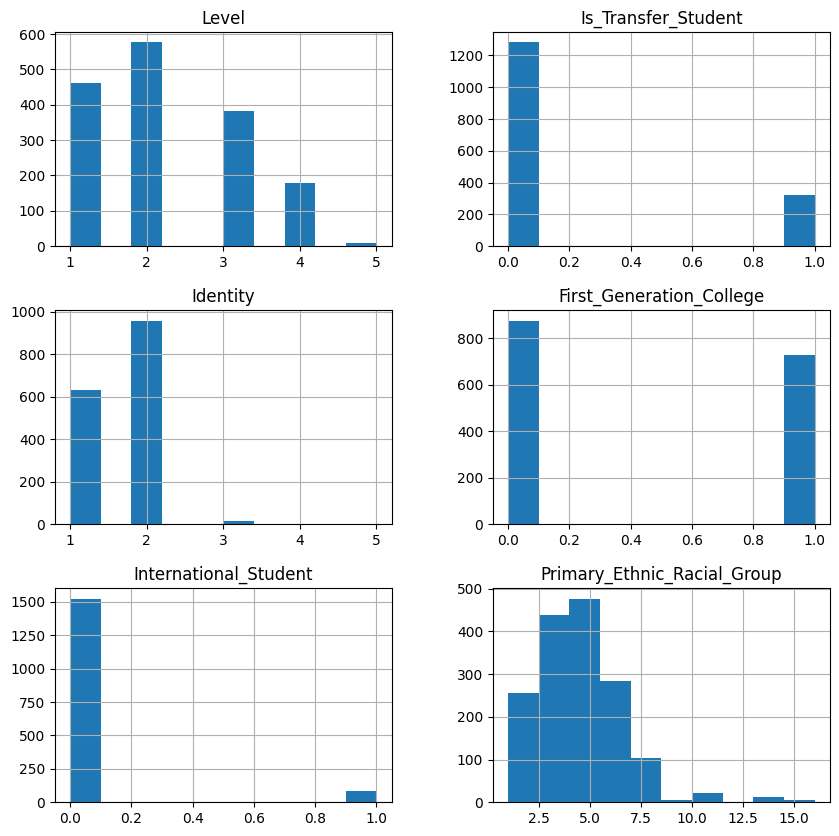

In [682]:
categorical_features = pd.concat([df.iloc[:,:2], df.iloc[:,13:]], axis=1)
ax = categorical_features.hist(figsize=(10,10))
plt.savefig(os.path.join('Plots', 'Histogram_of_qualitative_variables.png'))

We should remove under-represented data to ensure conclusiveness.

In [683]:
df = df[~df['Identity'].isin([3, 4, 5]) & ~df['Primary_Ethnic_Racial_Group'].isin(range(9, 18)) & (df['Level'] != 5)]
df.drop(columns=['International_Student'], inplace=True)
categorical_features.drop(columns=['International_Student'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1535 entries, 0 to 2301
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Level                        1535 non-null   int64  
 1   Is_Transfer_Student          1535 non-null   int64  
 2   Confidence_Graduate_Timely   1535 non-null   int64  
 3   Effective_Study_Strategies   1535 non-null   int64  
 4   Learning_Understanding       1535 non-null   int64  
 5   Breaking_Complex_Ideas       1535 non-null   int64  
 6   Time_Management              1535 non-null   int64  
 7   Self_Motivation              1535 non-null   int64  
 8   Access_Campus_Resources      1535 non-null   int64  
 9   Belonging_SJSU               1535 non-null   int64  
 10  Comfort_Asking_Help          1535 non-null   int64  
 11  Instructors_Care             1535 non-null   int64  
 12  Staff_Care                   1535 non-null   int64  
 13  Identity               

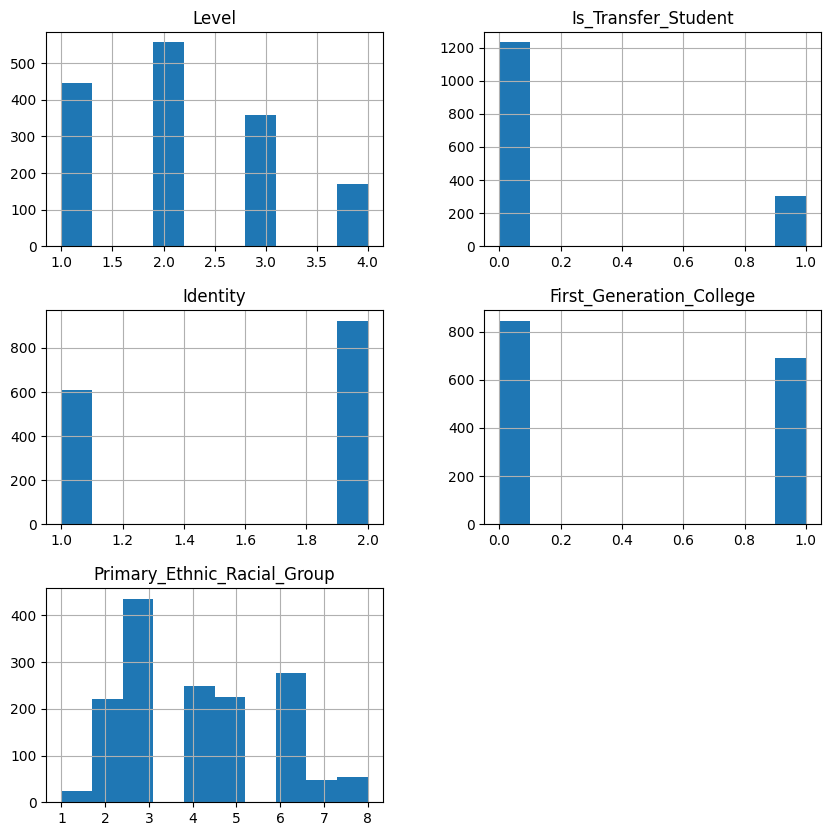

In [684]:
ax = df[categorical_features.columns].hist(figsize=(10,10))
plt.savefig(os.path.join('Plots', 'Histogram_of_qualitative_variables_post_drop.png'))


# Data Analysis

## Grouping

Perform ANOVA to determine the group differences

In [685]:
lst = list(range(3, 9))
lst.append(10)
target_group = df.iloc[:,lst]
target_group.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1535 entries, 0 to 2301
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Effective_Study_Strategies  1535 non-null   int64
 1   Learning_Understanding      1535 non-null   int64
 2   Breaking_Complex_Ideas      1535 non-null   int64
 3   Time_Management             1535 non-null   int64
 4   Self_Motivation             1535 non-null   int64
 5   Access_Campus_Resources     1535 non-null   int64
 6   Comfort_Asking_Help         1535 non-null   int64
dtypes: int64(7)
memory usage: 95.9 KB


## The impact of each category on others

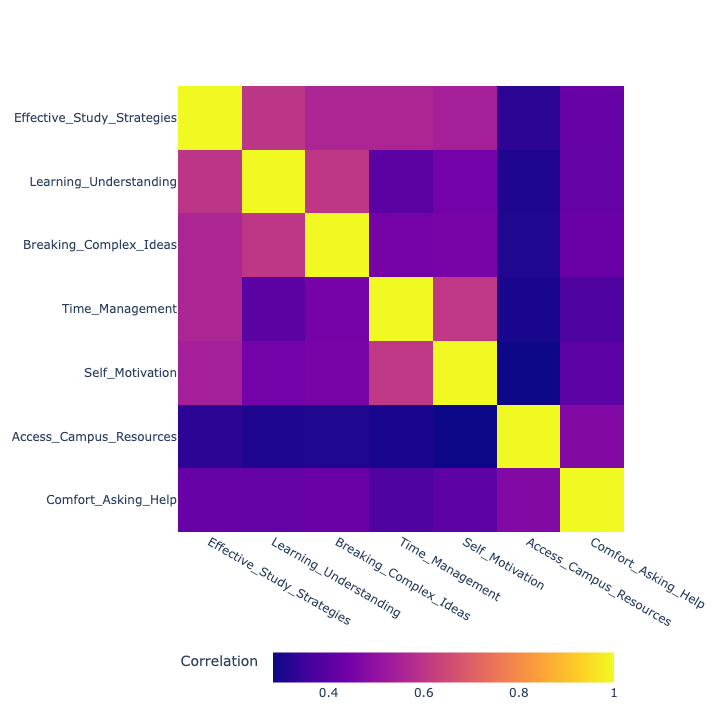

In [686]:
data_heatmap = df[target_group.columns]
fig = px.imshow(data_heatmap.corr(), 
                width=720, 
                height=720, 
                labels=dict(color='Correlation'))
fig.update_layout(
    coloraxis_colorbar=dict(
        orientation='h',  # Horizontal orientation
        x=0.5,  # Center it horizontally
        y=-0.3,  # Position it slightly above the plot
        xanchor='center',
        yanchor='bottom'
    )
)

fig.write_image(os.path.join('Plots/Heatmap_of_metrics_correlation.png'))
fig.show()

## Confidence Level by Ethnic Group

In [687]:
ethnic_group_remap = {
    1: 'West Asian',
    2: 'White/European/Canadian',
    3: 'Southeast Asian',
    4: 'South Asian',
    5: 'Latinx/Latina/Latino',
    6: 'East Asian',
    7: 'Chicanx/Chicana/Chicano',
    8: 'Black or African American'
}

df['Primary_Ethnic_Racial_Group'] = df['Primary_Ethnic_Racial_Group'].map(ethnic_group_remap)
group_by_ethnic = df.groupby("Primary_Ethnic_Racial_Group")[target_group.columns].mean()
group_by_ethnic = group_by_ethnic.reset_index()

data = group_by_ethnic.melt(id_vars='Primary_Ethnic_Racial_Group', value_name="Confident Level", var_name="Category")



In [688]:
group_by_ethnic

,Primary_Ethnic_Racial_Group,Effective_Study_Strategies,Learning_Understanding,Breaking_Complex_Ideas,Time_Management,Self_Motivation,Access_Campus_Resources,Comfort_Asking_Help
0,Black or African American,3.745455,4.000000,3.836364,3.218182,3.981818,3.854545,3.909091
1,Chicanx/Chicana/Chicano,3.382979,3.659574,3.468085,3.042553,3.489362,3.659574,3.574468
2,East Asian,3.703971,3.888087,3.703971,3.277978,3.617329,3.693141,3.837545
3,Latinx/Latina/Latino,3.702222,3.937778,3.600000,3.386667,3.853333,3.782222,3.733333
4,South Asian,4.044355,4.072581,3.947581,3.564516,3.939516,3.810484,3.899194
5,Southeast Asian,3.676606,3.908257,3.743119,3.261468,3.529817,3.786697,3.729358
6,West Asian,3.920000,4.080000,3.880000,3.400000,3.840000,3.680000,3.880000
7,White/European/Canadian,3.900901,4.054054,3.909910,3.418919,3.864865,3.788288,3.819820


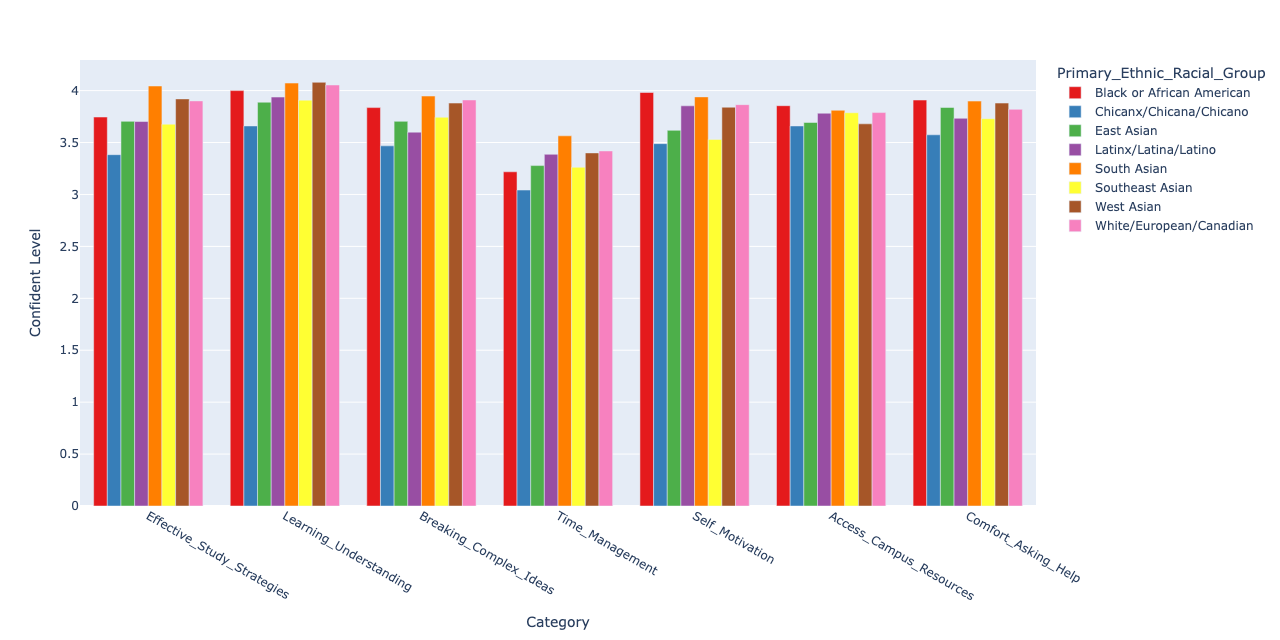

In [689]:
fig = px.bar(
    data,
    x="Category",
    y="Confident Level",
    color="Primary_Ethnic_Racial_Group", 
    barmode="group",
    width=1280,
    height=640,
    color_discrete_sequence=px.colors.qualitative.Set1,
)

# fig.show()
fig.write_image('Plots/Confident_Level_by_Level.png')
fig.show()

In [690]:
group_by_ethnic

,Primary_Ethnic_Racial_Group,Effective_Study_Strategies,Learning_Understanding,Breaking_Complex_Ideas,Time_Management,Self_Motivation,Access_Campus_Resources,Comfort_Asking_Help
0,Black or African American,3.745455,4.000000,3.836364,3.218182,3.981818,3.854545,3.909091
1,Chicanx/Chicana/Chicano,3.382979,3.659574,3.468085,3.042553,3.489362,3.659574,3.574468
2,East Asian,3.703971,3.888087,3.703971,3.277978,3.617329,3.693141,3.837545
3,Latinx/Latina/Latino,3.702222,3.937778,3.600000,3.386667,3.853333,3.782222,3.733333
4,South Asian,4.044355,4.072581,3.947581,3.564516,3.939516,3.810484,3.899194
5,Southeast Asian,3.676606,3.908257,3.743119,3.261468,3.529817,3.786697,3.729358
6,West Asian,3.920000,4.080000,3.880000,3.400000,3.840000,3.680000,3.880000
7,White/European/Canadian,3.900901,4.054054,3.909910,3.418919,3.864865,3.788288,3.819820


## Ethnic groups with most number of struggles

The data are ordinal, so consider Kruskal-Wallis and Dunn's post hoc test

In [691]:
target_group_tmp = target_group.copy()
target_group_tmp['Race'] = df['Primary_Ethnic_Racial_Group']

In [692]:
def kruskal_wallis_test(feature, data):
    group_col = feature
    target_group_tmp = data.copy()
    target_group_tmp[feature] = df[feature]
    # Separate features and groups
    features = target_group_tmp.drop(columns=[group_col]).columns
    groups = target_group_tmp[group_col].unique()
    
    passed_features = []
    # Perform Kruskal-Wallis test for each feature
    results = {}
    for feature in features:
        # Organize data by groups for the current feature
        group_data = [target_group_tmp[target_group_tmp[group_col] == group][feature] for group in groups]
        
        # Apply Kruskal-Wallis test
        stat, p_value = stats.kruskal(*group_data)
        
        # Save the result
        results[feature] = {'Statistic': stat, 'p-value': p_value}
        
        if p_value < 0.05:
            passed_features.append(feature)
    
    # Display results
    for feature, result in results.items():
        print(f"Feature: {feature}, Statistic: {result['Statistic']:.4f}, p-value: {result['p-value']:.4f}")
        
    print(f"Passed Features: {passed_features}")
    return passed_features

Feature: Effective_Study_Strategies, Statistic: 58.4848, p-value: 0.0000
Feature: Learning_Understanding, Statistic: 22.5008, p-value: 0.0021
Feature: Breaking_Complex_Ideas, Statistic: 39.3256, p-value: 0.0000
Feature: Time_Management, Statistic: 21.0208, p-value: 0.0037
Feature: Self_Motivation, Statistic: 53.4236, p-value: 0.0000
Feature: Access_Campus_Resources, Statistic: 6.4939, p-value: 0.4834
Feature: Comfort_Asking_Help, Statistic: 15.4368, p-value: 0.0308
Passed Features: ['Effective_Study_Strategies', 'Learning_Understanding', 'Breaking_Complex_Ideas', 'Time_Management', 'Self_Motivation', 'Comfort_Asking_Help']


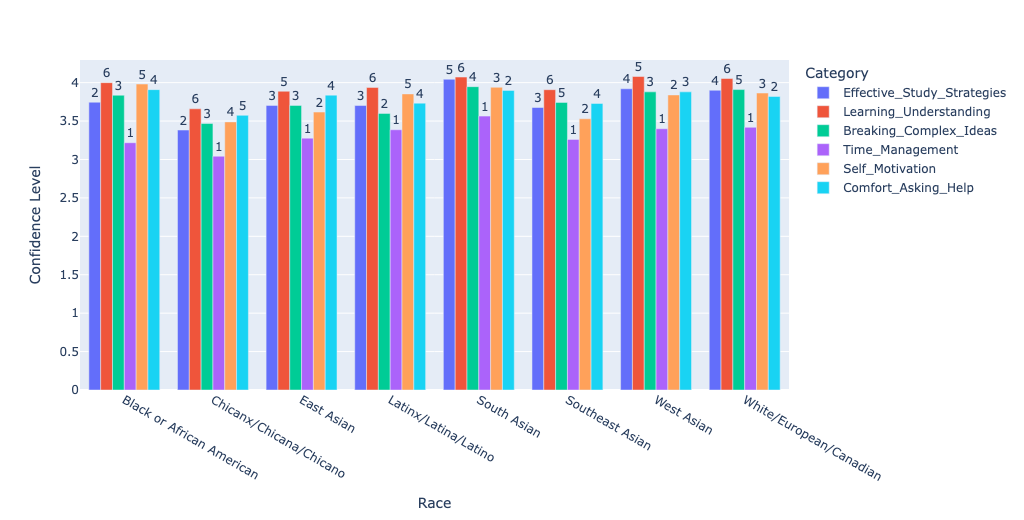

In [696]:
kruskal_wallis_test("Primary_Ethnic_Racial_Group", target_group)
plot_data = target_group_tmp.groupby('Race').mean().reset_index()
plot_data = plot_data.drop(columns=['Access_Campus_Resources']).melt(id_vars=['Race'], var_name="Category", value_name="Confidence Level")
# plot_data = plot_data.groupby(['Race', 'Category'])['Confidence Level'].mean()


plot_data['Rank'] = plot_data.groupby('Race')['Confidence Level'].rank(ascending=True, method='dense')
fig = px.bar(plot_data, x="Race", y="Confidence Level", color="Category", barmode='group', text='Rank', width=1024, height=520)

fig.update_traces(textposition='outside')
fig.show()
fig.write_image(os.path.join('Plots', 'Confidence Level by Ethnicity.png'))

# Year Level Comparison

In [697]:
# Define the mapping as a dictionary
level_group_remap = {
    1: 'Frosh',
    2: 'Sophomore',
    3: 'Junior',
    4: 'Senior'
}

# Map numeric levels to their names
df['Level'] = df['Level'].map(level_group_remap)

# Convert the 'Level' column to an ordered categorical variable
levels = list(level_group_remap.values())  # Extract the levels in order
df['Level'] = pd.Categorical(df['Level'], categories=levels, ordered=True)

# Group by 'Level' and calculate the mean of the target columns
group_by_level = df.groupby("Level")[target_group.columns].mean()
group_by_level = group_by_level.reset_index()

# Reshape the DataFrame for visualization
data = group_by_level.melt(id_vars='Level', value_name="Confident Level", var_name="Category")

/tmp/ipykernel_35391/2451617026.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



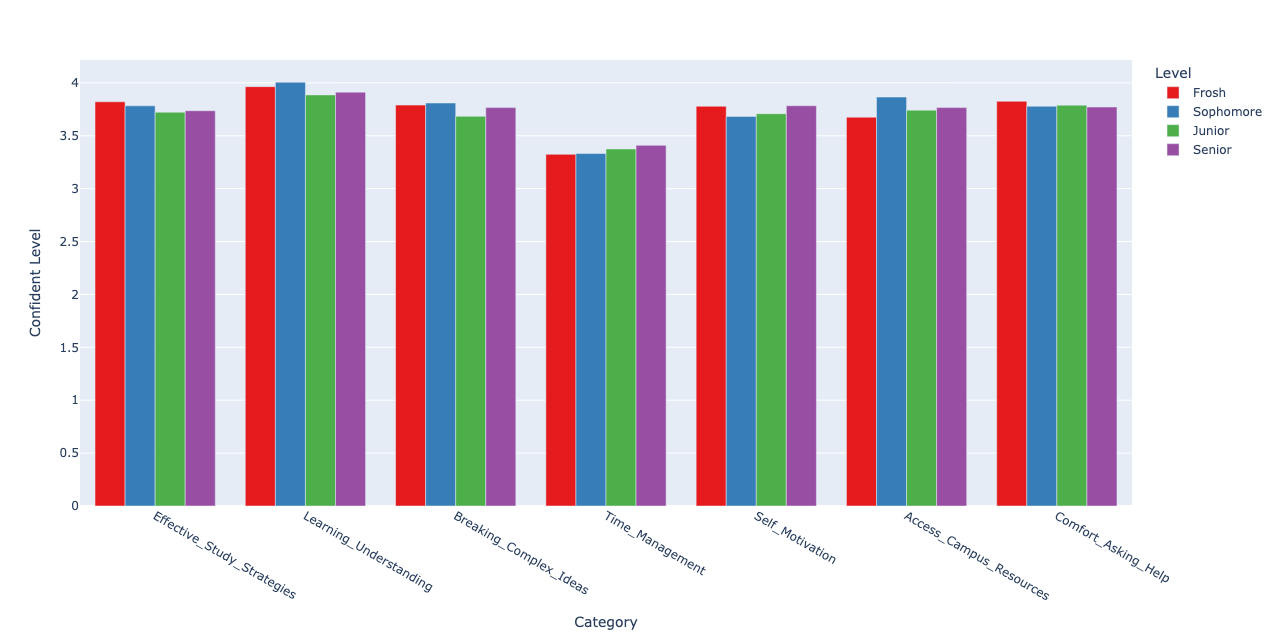

In [700]:
fig = px.bar(
    data,
    x="Category",
    y="Confident Level",
    color="Level", 
    barmode="group",
    width=1280,
    height=640,
    color_discrete_sequence=px.colors.qualitative.Set1,
)

# fig.show()
fig.write_image('Plots/Confident_Level_by_Level.png')
fig.show()

In [701]:
feature = kruskal_wallis_test("Level", target_group)

Feature: Effective_Study_Strategies, Statistic: 3.5413, p-value: 0.3154
Feature: Learning_Understanding, Statistic: 5.3232, p-value: 0.1496
Feature: Breaking_Complex_Ideas, Statistic: 5.6204, p-value: 0.1316
Feature: Time_Management, Statistic: 0.9165, p-value: 0.8215
Feature: Self_Motivation, Statistic: 4.0434, p-value: 0.2568
Feature: Access_Campus_Resources, Statistic: 12.8676, p-value: 0.0049
Feature: Comfort_Asking_Help, Statistic: 0.3813, p-value: 0.9441
Passed Features: ['Access_Campus_Resources']


/tmp/ipykernel_35391/540424585.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



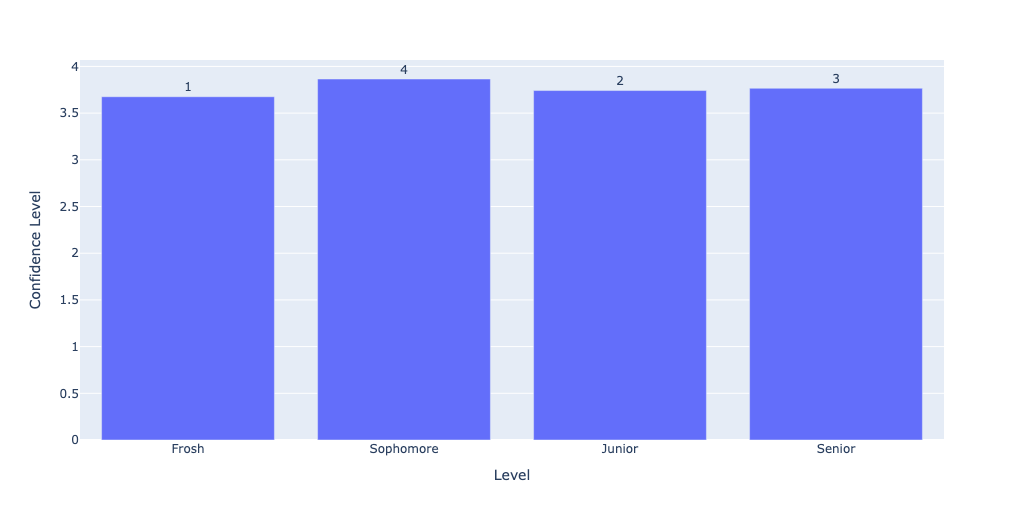

In [702]:
plot_data = df.groupby('Level')[feature].mean().reset_index()
plot_data["Rank"] = plot_data.rank().iloc[:,0]
fig = px.bar(plot_data, x="Level", y="Access_Campus_Resources", text='Rank', barmode='group', width=1024, height=520)

fig.update_traces(textposition='outside')
fig.update_layout(
    yaxis_title="Confidence Level"
)
fig.show()
fig.write_image(os.path.join('Plots', 'Confidence Level by Level at SJSU.png'))


# Gender x Transfer x FirstGen

In [723]:
identity_group_remap = {
    1: 'Female',
    2: 'Male',
}

transfer_group_remap = {
    0: 'Not_Transfer_Student',
    1: 'Is_Transfer_Student',
}

first_gen_group_remap = {
    0: 'Not_First_Gen_Student',
    1: 'Is_First_Gen_Student',
}

df['Identity'] = df['Identity'].map(identity_group_remap)
df['Is_Transfer_Student'] = df['Is_Transfer_Student'].map(transfer_group_remap)
df['First_Generation_College'] = df['First_Generation_College'].map(first_gen_group_remap)

df['Combined Group'] = df['Identity'] + '_' + df['Is_Transfer_Student'] + '_' + df['First_Generation_College']

In [725]:
df_tmp = df.groupby('Combined Group')[target_group.columns].mean().reset_index()

,Combined Group,Effective_Study_Strategies,Learning_Understanding,Breaking_Complex_Ideas,Time_Management,Self_Motivation,Access_Campus_Resources,Comfort_Asking_Help
0,Female_Is_Transfer_Student_Is_First_Gen_Student,3.901235,3.925926,3.716049,3.629630,4.037037,3.901235,3.851852
1,Female_Is_Transfer_Student_Not_First_Gen_Student,3.666667,3.854167,3.583333,3.333333,3.770833,3.520833,3.750000
2,Female_Not_Transfer_Student_Is_First_Gen_Student,3.605150,3.909871,3.660944,3.218884,3.587983,3.832618,3.690987
3,Female_Not_Transfer_Student_Not_First_Gen_Student,3.867470,3.995984,3.726908,3.401606,3.763052,3.783133,3.787149
4,Male_Is_Transfer_Student_Is_First_Gen_Student,3.608696,3.826087,3.652174,3.358696,3.652174,3.717391,3.750000
5,Male_Is_Transfer_Student_Not_First_Gen_Student,3.650602,3.891566,3.843373,3.289157,3.843373,3.614458,3.819277
6,Male_Not_Transfer_Student_Is_First_Gen_Student,3.699647,3.872792,3.678445,3.212014,3.674912,3.717314,3.738516
7,Male_Not_Transfer_Student_Not_First_Gen_Student,3.899142,4.057940,3.939914,3.429185,3.746781,3.804721,3.881974


In [728]:
# Group by 'Level' and calculate the mean of the target columns
group_by_combined = df.groupby("Combined Group")[target_group.columns].mean()
group_by_combined = group_by_combined.reset_index()

# Reshape the DataFrame for visualization
data = group_by_combined.melt(id_vars='Combined Group', value_name="Confident Level", var_name="Category")

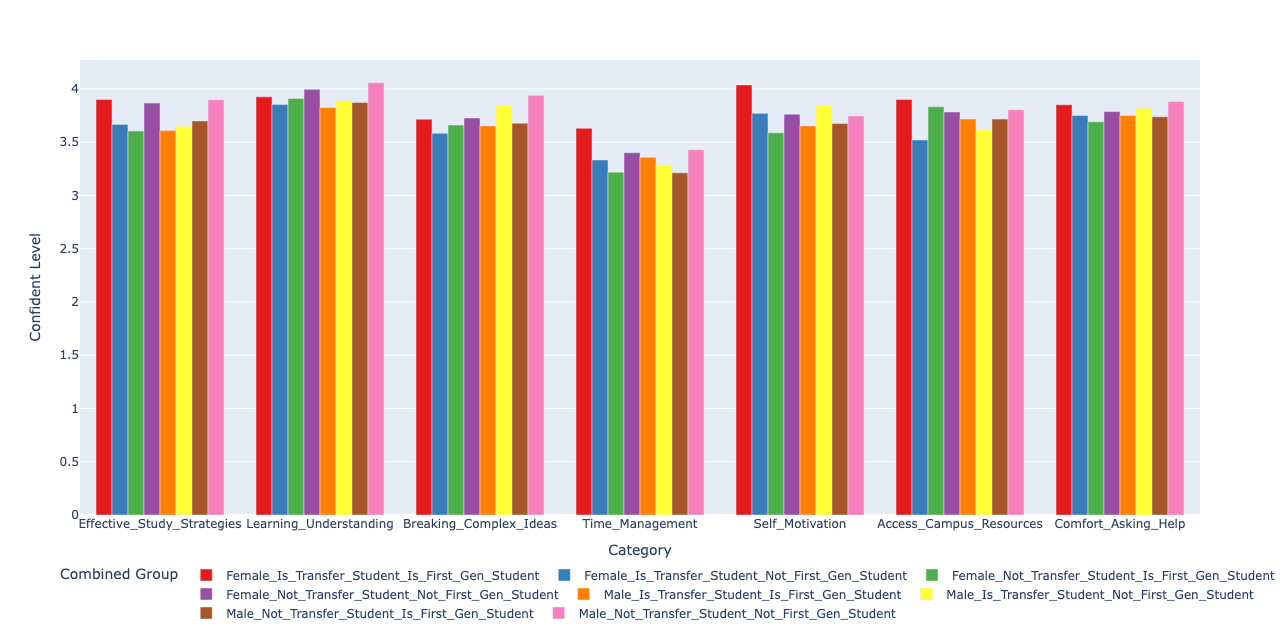

In [734]:
fig = px.bar(
    data,
    x="Category",
    y="Confident Level",
    color="Combined Group", 
    barmode="group",
    width=1280,
    height=640,
    color_discrete_sequence=px.colors.qualitative.Set1,
)

fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        # xanchor="center"
    )
)
# fig.show()
fig.write_image('Plots/Confident_Level_by_Combined.png')
fig.show()

In [736]:
features = kruskal_wallis_test("Combined Group", target_group)

Feature: Effective_Study_Strategies, Statistic: 31.1132, p-value: 0.0001
Feature: Learning_Understanding, Statistic: 13.4730, p-value: 0.0614
Feature: Breaking_Complex_Ideas, Statistic: 29.9446, p-value: 0.0001
Feature: Time_Management, Statistic: 15.7161, p-value: 0.0278
Feature: Self_Motivation, Statistic: 15.4330, p-value: 0.0308
Feature: Access_Campus_Resources, Statistic: 12.0416, p-value: 0.0992
Feature: Comfort_Asking_Help, Statistic: 9.4047, p-value: 0.2249
Passed Features: ['Effective_Study_Strategies', 'Breaking_Complex_Ideas', 'Time_Management', 'Self_Motivation']


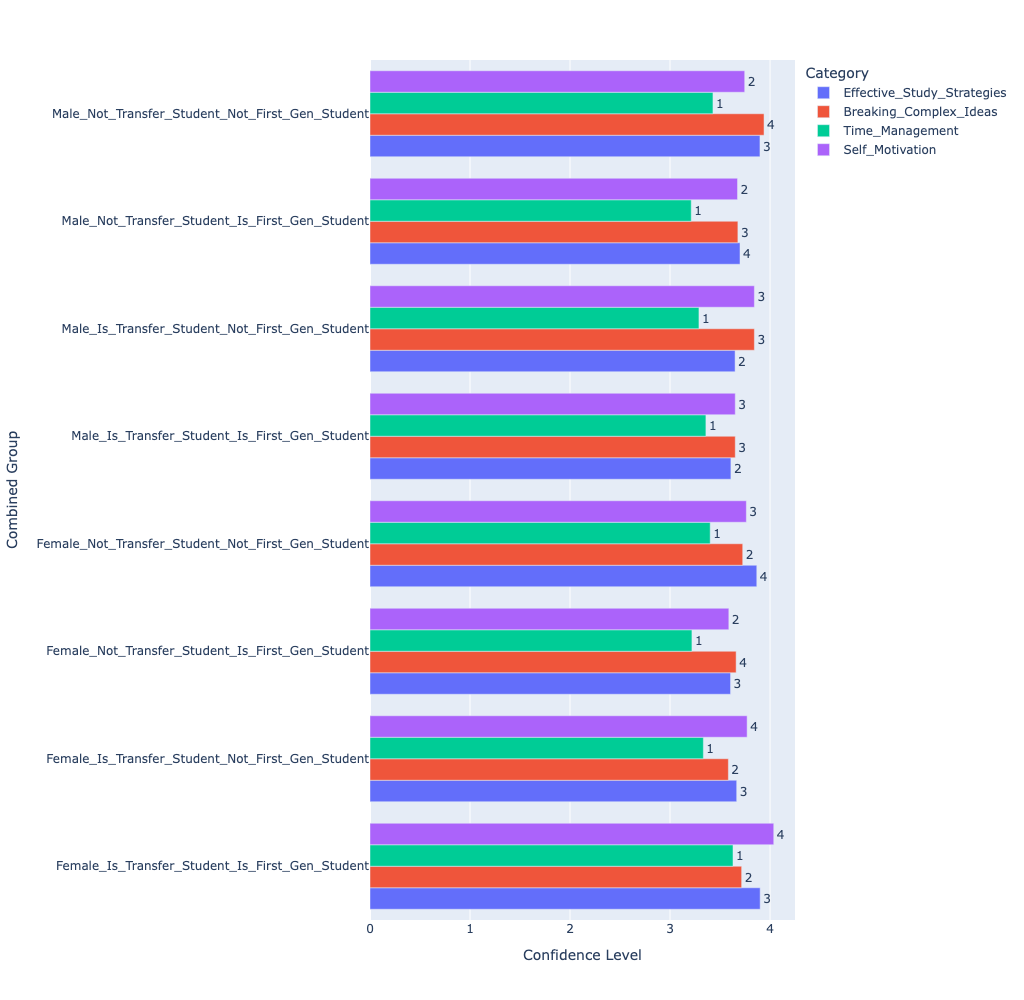

In [741]:
plot_data = df_tmp.groupby('Combined Group').mean().reset_index()
plot_data = plot_data.drop(columns=['Access_Campus_Resources', 'Learning_Understanding', 'Comfort_Asking_Help']).melt(id_vars=['Combined Group'], var_name="Category", value_name="Confidence Level")
# plot_data = plot_data.groupby(['Race', 'Category'])['Confidence Level'].mean()


plot_data['Rank'] = plot_data.groupby('Combined Group')['Confidence Level'].rank(ascending=True, method='dense')
fig = px.bar(plot_data, y="Combined Group", x="Confidence Level", color="Category", barmode='group', text='Rank', width=1024, height=1000)

fig.update_traces(textposition='outside')
fig.show()
fig.write_image(os.path.join('Plots', 'Confidence Level by Combined.png'))